# Explain different DL models for Sleep Staging with Spectral Gradients

In [1]:
from utils import set_root

from loguru import logger

import numpy as np
import torch

from tqdm import tqdm

from captum.attr import IntegratedGradients

from pytorch_lightning import seed_everything

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
import pandas as pd
import os

import seaborn as sns
from matplotlib import pyplot as plt

torch.backends.cudnn.enabled = False

seed_everything(42)
set_root()

Seed set to 42


Current working directory: /home/guido/github/dev/physioex-private


In [2]:
from physioex.data import TimeDistributedModule, SleepEDF, Shhs

from physioex.train.networks import config as networks
from physioex.train.networks.utils.loss import config as losses

from physioex.models import load_pretrained_model

from physioex.explain.spectralgradients import (
    SpectralGradients,
    generate_frequency_bands,
    plot,
)


from physioex.explain.spectralgradients.viz import plot_class_spectrum

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [36]:
# dataset
picks = ["EEG"]
fold = 0

# dataloader
batch_size = 512

# num of splitting bands
n_bands = 20

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = 21

## load chambon2018 and tinysleepnet to compare them

In [37]:
# model parameters
chambon = "chambon2018"
chambon = networks[chambon]
chambon = load_pretrained_model(
    name="chambon2018",
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=True,
).eval()

tiny = "tinysleepnet"
tiny = networks[tiny]
tiny = load_pretrained_model(
    name="tinysleepnet",
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=True,
).eval()

# convert tiny to multi-input single output considering the mid label of the sequence


class MidModel(torch.nn.Module):
    def __init__(self, model):
        super(MidModel, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)[:, int((x.shape[1] - 1) / 2)]


tiny = MidModel(tiny).eval()

1


/home/guido/github/dev/physioex-private/physioex/models/load.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["sequence_length"] == sequence_length ]
/home/guido/github/dev/physioex-private/physioex/models/load.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["in_channels"] == in_channels ]
/home/guido/github/dev/physioex-private/physioex/models/load.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["loss"] == loss ]
/home/guido/github/dev/physioex-private/physioex/models/load.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["sequence_length"] == sequence_length ]
/home/guido/github/dev/physioex-private/physioex/models/load.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  

In [38]:
# load dataset and model

dataset = Shhs(
    picks=picks,
    sequence_length=sequence_length,
    target_transform=networks["chambon2018"]["target_transform"],
    preprocessing=networks["chambon2018"]["input_transform"],
)

dataset.split(fold=fold)

dataset = TimeDistributedModule(
    dataset=dataset, batch_size=batch_size, fold=fold, num_workers=os.cpu_count()
)


# setup the explanations algorithms
chambon_sg = SpectralGradients(chambon, n_bands=n_bands, mode="log")
tiny_sg = SpectralGradients(tiny, n_bands=n_bands, mode="log")

chambon_ig = IntegratedGradients(chambon)
tiny_ig = IntegratedGradients(tiny)

Frequency bands: [[0.09999999999999999, 0.1363043775957031], [0.1363043775957031, 0.18578883351752018], [0.18578883351752018, 0.253238313168373], [0.253238313168373, 0.34517490659800826], [0.34517490659800826, 0.4704885080549647], [0.4704885080549647, 0.6412964325636293], [0.6412964325636293, 0.874115110949303], [0.874115110949303, 1.1914571614494371], [1.1914571614494371, 1.624008268233087], [1.624008268233087, 2.213594362117866], [2.213594362117866, 3.0172260177783334], [3.0172260177783334, 4.112611144188375], [4.112611144188375, 5.605669023017489], [5.605669023017489, 7.640772271899125], [7.640772271899125, 10.41470708871716], [10.41470708871716, 14.195701675691504], [14.195701675691504, 19.349362814394112], [19.349362814394112, 26.374028552894305], [26.374028552894305, 35.948955465935626], [35.948955465935626, 49.0]]
Frequency bands: [[0.09999999999999999, 0.1363043775957031], [0.1363043775957031, 0.18578883351752018], [0.18578883351752018, 0.253238313168373], [0.253238313168373, 0

In [17]:
X, y_chambon, y_tiny = [], [], []

with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(dataset.test_dataloader())):
        # take only the elements belonging to the NREM2 class
        x = x[y == 2]
        # if x is empty, skip
        if x.shape[0] == 0:
            continue

        # take the corrected classified elements from tiny
        tiny_probas = tiny(x.to(device)).detach().cpu()
        tiny_labels = torch.argmax(tiny_probas, dim=1)

        x = x[tiny_labels == 2]
        if x.shape[0] == 0:
            continue

        tiny_probas = tiny_probas[tiny_labels == 2]

        # take the uncorrected classified elements from chambon

        chambon_probas = chambon(x.to(device)).detach().cpu()
        chambon_labels = torch.argmax(chambon_probas, dim=1)

        x = x[chambon_labels != 2]
        if x.shape[0] == 0:
            continue

        X.extend(x)
        y_chambon.extend(chambon_probas[chambon_labels != 2])
        y_tiny.extend(tiny_probas[chambon_labels != 2])

        break

X = torch.stack(X)
y_chambon = torch.stack(y_chambon)
y_tiny = torch.stack(y_tiny)


print(X.shape, y_chambon.shape, y_tiny.shape)

torch.Size([40343, 21, 1, 3000]) torch.Size([40343, 5]) torch.Size([40343, 5])


In [18]:
def smooth_importance(heatmap, n=3):
    heatmap = heatmap.copy()

    for i in range(heatmap.shape[0]):  # 20

        # start 0, end -n, step n
        for j in range(0, heatmap.shape[1] - n, n):
            # take the sign of the maximum abs value in the window
            # max_index = np.argmax(np.abs(heatmap[i, j : j + n]))
            # max_value = heatmap[i, j : j + n][max_index]

            heatmap[i, j : j + n] = np.ones(n) * heatmap[i, j : j + n].sum()

    return heatmap

In [39]:
# consider the first element of X, compute the importances for both models
id = 0
x = X[id].unsqueeze(0)
chambon_target = torch.argmax(y_chambon, dim=1)[id]
tiny_target = torch.argmax(y_tiny, dim=1)[id]

print(f"Predicted class by chambonnet: {chambon_target}")
print(f"Predicted class by tinysleepnet: {tiny_target}")

print(f"Chambon probabilities {y_chambon[id]}")
print(f"Tiny probabilities {y_tiny[id]}")

with torch.no_grad():
    chambon_attr = (
        chambon_sg.attribute(x.to(device), target=tiny_target).detach().cpu().numpy()
    )
    tiny_attr = (
        tiny_sg.attribute(x.to(device), target=tiny_target).detach().cpu().numpy()
    )

    chambon_ig_attr = (
        chambon_ig.attribute(x.to(device), target=tiny_target).detach().cpu().numpy()
    )
    tiny_ig_attr = (
        tiny_ig.attribute(x.to(device), target=tiny_target).detach().cpu().numpy()
    )


chambon_attr = np.transpose(np.squeeze(chambon_attr), (0, 2, 1))
tiny_attr = np.transpose(np.squeeze(tiny_attr), (0, 2, 1))

chambon_ig_attr = np.squeeze(chambon_ig_attr)
tiny_ig_attr = np.squeeze(tiny_ig_attr)

print(chambon_attr.shape, tiny_attr.shape, chambon_ig_attr.shape, tiny_ig_attr.shape)

Predicted class by chambonnet: 3
Chambon probabilities tensor([1.4609e-03, 1.7652e-04, 3.9065e-01, 6.0762e-01, 9.2635e-05])
Tiny probabilities tensor([5.6513e-03, 3.4769e-04, 6.9417e-01, 2.9926e-01, 5.7095e-04])
(21, 20, 3000) (21, 20, 3000) (21, 3000) (21, 3000)


In [40]:
# compute the approximation error

chambon_err = np.linalg.norm(chambon_ig_attr - chambon_attr.sum(axis=1))
tiny_err = np.linalg.norm(tiny_ig_attr - tiny_attr.sum(axis=1))

print(f"Chambon error {chambon_err}")
print(f"Tiny error {tiny_err}")

print(chambon_attr.shape)

Chambon error 0.24356527920298668
Tiny error 0.14501848663468164
(21, 20, 3000)


Frequency bands: [[0.09999999999999999, 0.1363043775957031], [0.1363043775957031, 0.18578883351752018], [0.18578883351752018, 0.253238313168373], [0.253238313168373, 0.34517490659800826], [0.34517490659800826, 0.4704885080549647], [0.4704885080549647, 0.6412964325636293], [0.6412964325636293, 0.874115110949303], [0.874115110949303, 1.1914571614494371], [1.1914571614494371, 1.624008268233087], [1.624008268233087, 2.213594362117866], [2.213594362117866, 3.0172260177783334], [3.0172260177783334, 4.112611144188375], [4.112611144188375, 5.605669023017489], [5.605669023017489, 7.640772271899125], [7.640772271899125, 10.41470708871716], [10.41470708871716, 14.195701675691504], [14.195701675691504, 19.349362814394112], [19.349362814394112, 26.374028552894305], [26.374028552894305, 35.948955465935626], [35.948955465935626, 49.0]]
torch.Size([1, 21, 1, 3000])


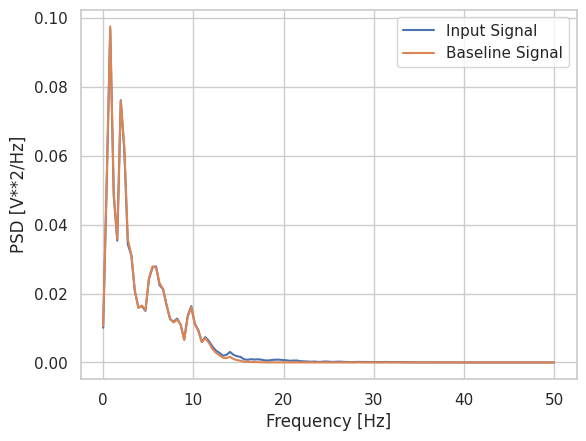

In [41]:
from scipy.signal import welch
import matplotlib.pyplot as plt

baseline = SpectralGradients(chambon, n_bands=20, mode="log")._construct_baseline(x)

# b è il tuo segnale
b = baseline[0, 0, 0, :, 16].numpy()
print(x.shape)
# Calcola lo spettro di potenza
frequencies, power_spectrum = welch(x[0, 0, 0], fs=100)

# Traccia lo spettro di potenza
sns.lineplot(x=frequencies, y=power_spectrum, label="Input Signal")

frequencies, power_spectrum = welch(b, fs=100)
sns.lineplot(x=frequencies, y=power_spectrum, label="Baseline Signal")

plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.legend()
plt.show()

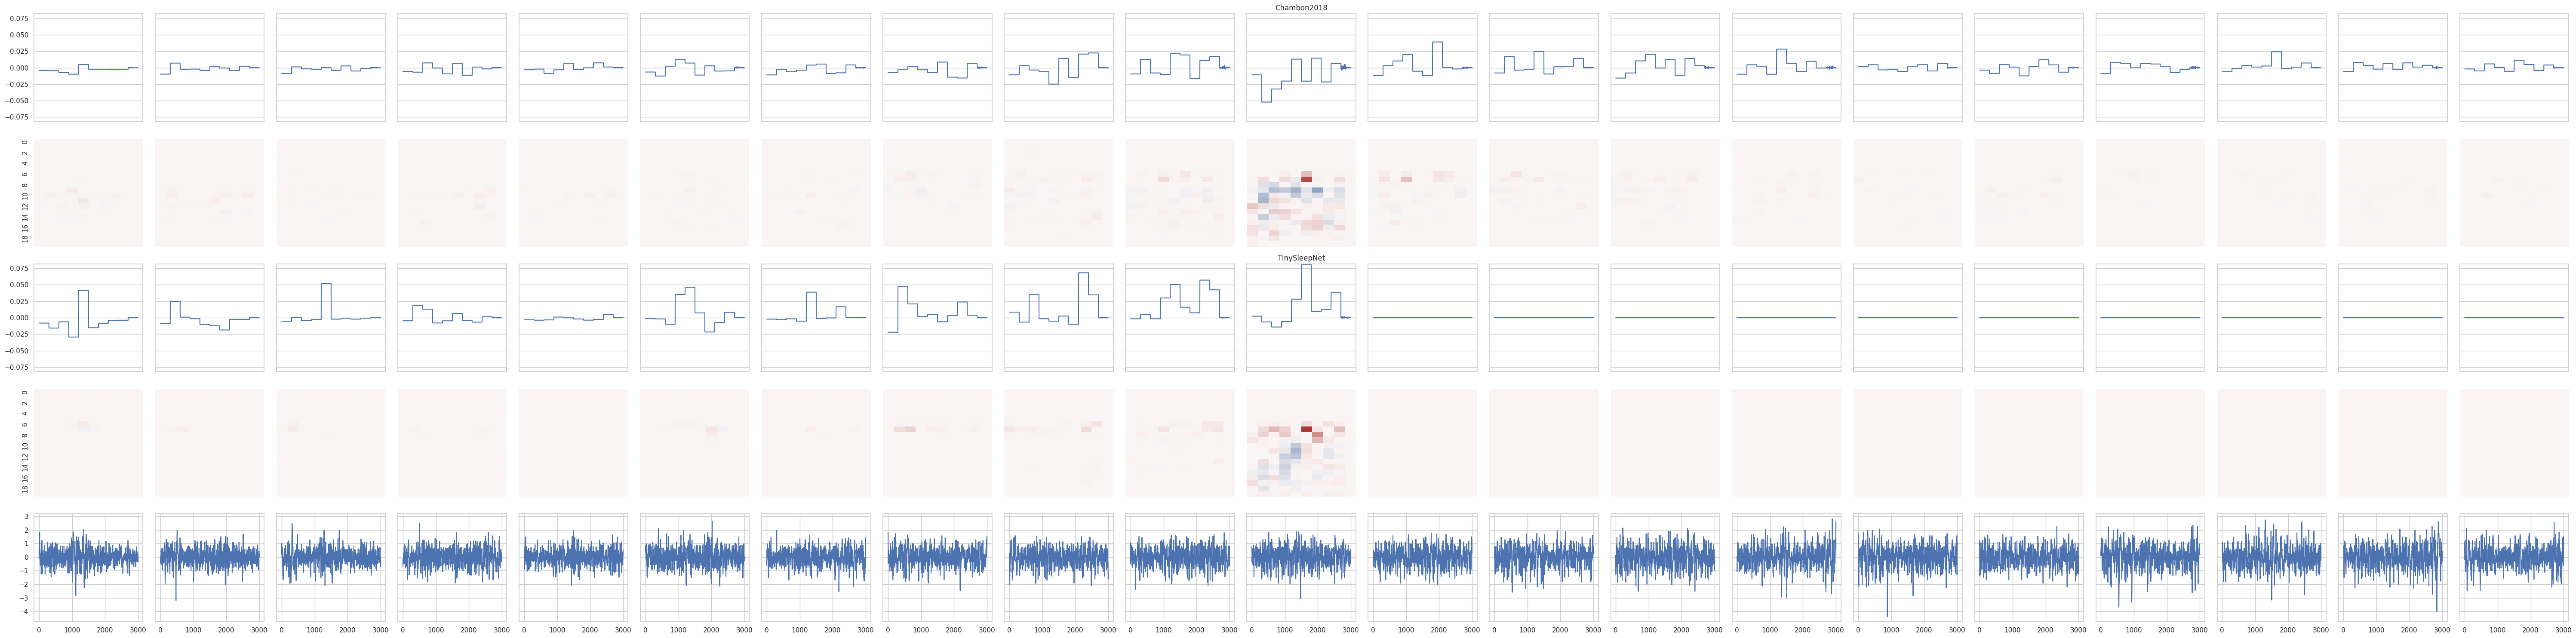

In [42]:
# plot the spectral and ig importances and the input signal for both models

fig, ax = plt.subplots(
    nrows=5,
    ncols=sequence_length,
    figsize=(60, 15),
    sharey="row",
    # height_ratios=[1/n_bands, 1, 1/n_bands, 1, 1]
)

# plot the input signal in the last row

chambon_plot = [
    smooth_importance(chambon_attr[i], n=300) for i in range(sequence_length)
]
tiny_plot = [smooth_importance(tiny_attr[i], n=300) for i in range(sequence_length)]

tiny_plot = np.array(tiny_plot)
chambon_plot = np.array(chambon_plot)

chambon_ig_plot = np.array(
    [
        smooth_importance(np.expand_dims(chambon_ig_attr[i], axis=0), n=300)
        for i in range(sequence_length)
    ]
)
tiny_ig_plot = np.array(
    [
        smooth_importance(np.expand_dims(tiny_ig_attr[i], axis=0), n=300)
        for i in range(sequence_length)
    ]
)

vmax = np.max(
    [
        np.max(tiny_plot),
        np.max(chambon_plot),
        np.max(chambon_ig_plot),
        np.max(tiny_ig_plot),
    ]
)
vmin = -vmax

for i in range(sequence_length):

    sns.lineplot(x=np.arange(x.shape[-1]), y=x[0, i, 0].numpy(), ax=ax[4, i])

    # attributions plot of chambon2018
    sns.lineplot(
        x=np.arange(x.shape[-1]),
        y=np.squeeze(chambon_ig_plot[i]),
        ax=ax[0, i],
        # cmap="vlag",
        # vmax=vmax,
        # vmin=vmin,
        # cbar=False,
    )
    ax[0, i].set_xticks([])
    ax[0, i].set_ylim(vmin, vmax)
    sns.heatmap(
        chambon_plot[i],
        ax=ax[1, i],
        cmap="vlag",
        vmax=vmax,
        vmin=vmin,
        cbar=False,
    )
    # hide xticks for the first two rows
    ax[1, i].set_xticks([])

    # attributions plot of tinysleepnet
    sns.lineplot(
        x=np.arange(x.shape[-1]),
        y=np.squeeze(tiny_ig_plot[i]),
        ax=ax[2, i],
        # cmap="vlag",
        # vmax=vmax,
        # vmin=vmin,
        # cbar=False,
    )
    ax[2, i].set_xticks([])
    ax[2, i].set_ylim(vmin, vmax)
    sns.heatmap(
        tiny_plot[i],
        ax=ax[3, i],
        cmap="vlag",
        vmax=vmax,
        vmin=vmin,
        cbar=False,
    )
    ax[3, i].set_xticks([])

# set the first two rows title as chambon2018
ax[0, int(sequence_length / 2)].set_title("Chambon2018")
ax[2, int(sequence_length / 2)].set_title("TinySleepNet")

plt.tight_layout()
plt.show()